### clone the required repositories

In [3]:
!git clone https://github.com/zhoudaquan/dvit_repo.git
!git clone https://github.com/facebookresearch/deit.git

Cloning into 'dvit_repo'...
remote: Enumerating objects: 644, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (210/210), done.
remote: Total 644 (delta 48), reused 245 (delta 46), pack-reused 384
Receiving objects: 100% (644/644), 22.25 MiB | 2.53 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Cloning into 'deit'...
remote: Enumerating objects: 456, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 456 (delta 188), reused 151 (delta 150), pack-reused 244
Receiving objects: 100% (456/456), 5.72 MiB | 1.37 MiB/s, done.
Resolving deltas: 100% (262/262), done.


### Install the requirements

In [11]:
# Setup all the required libraries
%pip install ultralytics torch torchvision transforms pandas timm numpy seaborn num2words scikit-learn rich

  Using cached transforms-0.2.1-py3-none-any.whl.metadata (1.8 kB)

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Load all the necessary libraries

In [12]:
import os
import cv2
import sys
import json
import timm
import torch
import random
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
import torch.nn as nn
from ultralytics import YOLO
from functools import partial
from num2words import num2words
from IPython.display import display, Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    f1_score,
    classification_report,
    confusion_matrix,
)

from tqdm import tqdm
from rich import print
from timm.data import ImageDataset
from timm.data.loader import create_loader
from timm.models import create_model, load_checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.vision_transformer import VisionTransformer, _cfg
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

from timm.optim import create_optimizer
from timm.scheduler import create_scheduler
from timm.utils import ApexScaler, NativeScaler
from timm.models.registry import register_model
from dvit_repo.utils.flops_counter import get_model_complexity_info
from timm.models.layers import trunc_normal_


from deit.models import *
from deit.models_v2 import *

from IPython import display

display.clear_output()

import ultralytics

ultralytics.checks()

timm.__version__

Ultralytics YOLOv8.1.38 🚀 Python-3.11.5 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090 Laptop GPU, 15981MiB)
Setup complete ✅ (32 CPUs, 31.0 GB RAM, 1250.9/1811.5 GB disk)


'1.0.3'

### Prepare the datatset and calculate the number of Images 

In [2]:
# Prepare the dataset

root = "../Dataset/Landscape Classification/"
training_path = root + "train"
validation_path = root + "val"


def read_split_data(root, plot_image=False):
    filepaths_train = []
    labels_train = []

    filepaths_validation = []
    labels_validation = []

    bad_images_train = []
    bad_images_validation = []

    random.seed(0)

    assert os.path.exists(root), "The specified root path doesn't exist"

    classes_train = [
        c
        for c in os.listdir(training_path)
        if os.path.isdir(os.path.join(training_path, c))
    ]
    classes_train.sort()

    class_indices = {k: v for v, k in enumerate(classes_train)}

    print("The created class indices are: \n", class_indices)

    json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)

    with open("class_indices.json", "w") as json_file:
        json_file.write(json_str)

    every_class_num = []
    every_class_num_val = []

    supported = [".jpg", ".png", ".jpeg", ".PNG", ".JPG", ".JPEG"]

    print("Training Images:")
    for c in classes_train:
        # Gather Training Images
        classpath_train = os.path.join(training_path, c)

        if not os.path.exists(classpath_train):
            print(f"{classpath_train} doesn't exist")

        images_train = [
            os.path.join(training_path, c, i)
            for i in os.listdir(classpath_train)
            if os.path.splitext(i)[-1] in supported
        ]

        every_class_num.append(len(images_train))
        file_list_train = sorted(os.listdir(classpath_train))

        desc = f"{c:23}"

        for f in tqdm(
            file_list_train, ncols=110, desc=desc, unit="file", colour="green"
        ):
            fpath = os.path.join(classpath_train, f)
            fl = f.lower()
            index = f.rfind(".")
            ext = f[index:]

            if ext in supported:
                try:
                    cv2.imread(fpath)
                    filepaths_train.append(fpath)
                    labels_train.append(c)
                except:
                    bad_images_train.append(fpath)
                    print("defective image path: ", fpath)
            else:
                bad_images_train.append(fpath)

    validation = [
        v
        for v in os.listdir(validation_path)
        if os.path.isdir(os.path.join(validation_path, v))
    ]
    validation.sort()

    validation_indices = {k: v for v, k in enumerate(validation)}

    print("Validation Images: ")

    for v in validation:
        # Gather Training Images
        classpath_validation = os.path.join(validation_path, v)
        images_validation = [
            os.path.join(validation_path, v, i)
            for i in os.listdir(classpath_validation)
            if os.path.splitext(i)[-1] in supported
        ]

        every_class_num_val.append(len(images_validation))
        file_list_validation = sorted(os.listdir(classpath_validation))

        desc = f"{v:23}"

        for f in tqdm(
            file_list_validation, ncols=110, desc=desc, unit="file", colour="green"
        ):
            fpath = os.path.join(classpath_validation, f)
            fl = f.lower()
            index = f.rfind(".")
            ext = f[index:]

            if ext in supported:
                try:
                    cv2.imread(fpath)
                    filepaths_validation.append(fpath)
                    labels_validation.append(v)
                except:
                    bad_images_validation.append(fpath)
                    print("defective image path: ", fpath)
            else:
                bad_images_validation.append(fpath)

    train_filepath_series = pd.Series(filepaths_train, name="training_filepaths")
    validation_filepath_series = pd.Series(
        filepaths_validation, name="validation_filepaths"
    )

    train_label_series = pd.Series(labels_train, name="labels_train")
    validation_label_series = pd.Series(labels_validation, name="labels_validation")

    df_train = pd.concat([train_filepath_series, train_label_series], axis=1)

    print(
        f"{len(df_train.labels_train.unique())} kind of training images were found in the dataset"
    )

    df_validation = pd.concat(
        [validation_filepath_series, validation_label_series], axis=1
    )
    print(
        f"{len(df_validation.labels_validation.unique())} kind of validation images were found in the dataset"
    )
    # dump the filepaths and labels for training and validation
    df_train.to_csv("train_dump.csv")
    df_validation.to_csv("validation_dump.csv")

    image_label_train = [class_indices[i] for i in df_train["labels_train"].tolist()]
    image_label_val = [
        class_indices[i] for i in df_validation["labels_validation"].tolist()
    ]

    sample_df_train = df_train.sample(n=50, replace=False)
    sample_df_validation = df_validation.sample(n=50, replace=False)

    print(sample_df_train)
    print(sample_df_validation)

    ht, wt, count = 0, 0, 0
    for i in range(len(sample_df_train)):
        fpath = sample_df_train["training_filepaths"].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            ht += h
            wt += w
            count += 1
        except:
            pass

    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave

    print(
        "average image height= ",
        have,
        "  average image width= ",
        wave,
        " aspect ratio h/w= ",
        aspect_ratio,
    )

    print(
        "{} images were found in the dataset.\n{} for training, {} for validation".format(
            sum(every_class_num), len(filepaths_train), len(filepaths_validation)
        )
    )
    if plot_image:
        print("Training Image")
        plt.bar(range(len(classes_train)), every_class_num, align="center")
        plt.xticks(range(len(classes_train)), classes_train)

        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha="center")

        plt.xlabel("image class")
        plt.ylabel("number of images")

        plt.title("class distribution for training images")
        plt.show()

    return (
        filepaths_train,
        filepaths_validation,
        image_label_train,
        image_label_val,
        class_indices,
    )


filepath_list_tr, filepath_list_val, label_tr, label_val, cls_indices = read_split_data(
    root=root
)

with open("fpath_tr.txt", "a") as f:
    for i in filepath_list_tr:
        f.write(i)

The created class indices are: 

{'Coast': 0, 'Desert': 1, 'Forest': 2, 'Glacier': 3, 'Mountain': 4}

Training Images:

Mountain               : 100%|█████████████████████████████████████████| 2000/2000 [00:02<00:00, 893.87file/s]


Validation Images:

Mountain               : 100%|██████████████████████████████████████████| 300/300 [00:00<00:00, 1064.60file/s]


5 kind of training images were found in the dataset

5 kind of validation images were found in the dataset

training_filepaths labels_train
3009  ../Dataset/Landscape Classification/train/Dese...       Desert
3101  ../Dataset/Landscape Classification/train/Dese...       Desert
1634  ../Dataset/Landscape Classification/train/Coas...        Coast
7467  ../Dataset/Landscape Classification/train/Glac...      Glacier
6132  ../Dataset/Landscape Classification/train/Glac...      Glacier
897   ../Dataset/Landscape Classification/train/Coas...        Coast
6393  ../Dataset/Landscape Classification/train/Glac...      Glacier
9394  ../Dataset/Landscape Classification/train/Moun...     Mountain
7014  ../Dataset/Landscape Classification/train/Glac...      Glacier
5643  ../Dataset/Landscape Classification/train/Fore...       Forest
2321  ../Dataset/Landscape Classification/train/Dese...       Desert
3762  ../Dataset/Landscape Classification/train/Dese...       Desert
8363  ../Dataset/Landscape Classification/train/Moun...     Mountain
2757  ../Dataset/Landscape Classification/train/Dese...       Desert
1737  ../Dataset/Landscape Classification/train/Coas...        Coast
2695  ../Dataset/Landscape Classification/train/Dese...       Desert
2232  ../Dataset/Landscape Classification/train/Dese...       Desert
7657  ../Dataset/Landscape Classification/train/Glac...      Glacier
9905  ../Dataset/Landscape Classification/train/Moun...     Mountain
1173  ../Dataset/Landscape Classification/train/Coas...        Coast
4304  ../Dataset/Landscape Classification/train/Fore...       Forest
5435  ../Dataset/Landscape Classification/train/Fore...       Forest
7984  ../Dataset/Landscape Classification/train/Glac...      Glacier
6274  ../Dataset/Landscape Classification/train/Glac...      Glacier
1911  ../Dataset/Landscape Classification/train/Coas...        Coast
2474  ../Dataset/Landscape Classification/train/Dese...       Desert
4377  ../Dataset/Landscape Classification/train/Fore...       Forest
810   ../Dataset/Landscape Classification/train/Coas...        Coast
708   ../Dataset/Landscape Classification/train/Coas...        Coast
963   ../Dataset/Landscape Classification/train/Coas...        Coast
191   ../Dataset/Landscape Classification/train/Coas...        Coast
3768  ../Dataset/Landscape Classification/train/Dese...       Desert
409   ../Dataset/Landscape Classification/train/Coas...        Coast
9776  ../Dataset/Landscape Classification/train/Moun...     Mountain
7262  ../Dataset/Landscape Classification/train/Glac...      Glacier
1996  ../Dataset/Landscape Classification/train/Coas...        Coast
81    ../Dataset/Landscape Classification/train/Coas...        Coast
1306  ../Dataset/Landscape Classification/train/Coas...        Coast
1074  ../Dataset/Landscape Classification/train/Coas...        Coast
8832  ../Dataset/Landscape Classification/train/Moun...     Mountain
4698  ../Dataset/Landscape Classification/train/Fore...       Forest
234   ../Dataset/Landscape Classification/train/Coas...        Coast
5782  ../Dataset/Landscape Classification/train/Fore...       Forest
6783  ../Dataset/Landscape Classification/train/Glac...      Glacier
1055  ../Dataset/Landscape Classification/train/Coas...        Coast
7476  ../Dataset/Landscape Classification/train/Glac...      Glacier
109   ../Dataset/Landscape Classification/train/Coas...        Coast
4289  ../Dataset/Landscape Classification/train/Fore...       Forest
4335  ../Dataset/Landscape Classification/train/Fore...       Forest
7364  ../Dataset/Landscape Classification/train/Glac...      Glacier

validation_filepaths labels_validation
50    ../Dataset/Landscape Classification/val/Coast/...             Coast
1311  ../Dataset/Landscape Classification/val/Mounta...          Mountain
473   ../Dataset/Landscape Classification/val/Desert...            Desert
1037  ../Dataset/Landscape Classification/val/Glacie...           Glacier
1235  ../Dataset/Landscape Classification/val/Mounta...          Mountain
351   ../Dataset/Landscape Classification/val/Desert...            Desert
626   ../Dataset/Landscape Classification/val/Forest...            Forest
120   ../Dataset/Landscape Classification/val/Coast/...             Coast
784   ../Dataset/Landscape Classification/val/Forest...            Forest
1051  ../Dataset/Landscape Classification/val/Glacie...           Glacier
415   ../Dataset/Landscape Classification/val/Desert...            Desert
1004  ../Dataset/Landscape Classification/val/Glacie...           Glacier
1475  ../Dataset/Landscape Classification/val/Mounta...          Mountain
149   ../Dataset/Landscape Classification/val/Coast/...             Coast
616   ../Dataset/Landscape Classification/val/Forest...            Forest
1271  ../Dataset/Landscape Classification/val/Mounta...          Mountain
707   ../Dataset/Landscape Classification/val/Forest...            Forest
17    ../Dataset/Landscape Classification/val/Coast/...             Coast
883   ../Dataset/Landscape Classification/val/Forest...            Forest
1056  ../Dataset/Landscape Classification/val/Glacie...           Glacier
613   ../Dataset/Landscape Classification/val/Forest...            Forest
1438  ../Dataset/Landscape Classification/val/Mounta...          Mountain
444   ../Dataset/Landscape Classification/val/Desert...            Desert
978   ../Dataset/Landscape Classification/val/Glacie...           Glacier
1086  ../Dataset/Landscape Classification/val/Glacie...           Glacier
1226  ../Dataset/Landscape Classification/val/Mounta...          Mountain
179   ../Dataset/Landscape Classification/val/Coast/...             Coast
353   ../Dataset/Landscape Classification/val/Desert...            Desert
421   ../Dataset/Landscape Classification/val/Desert...            Desert
1478  ../Dataset/Landscape Classification/val/Mounta...          Mountain
265   ../Dataset/Landscape Classification/val/Coast/...             Coast
1365  ../Dataset/Landscape Classification/val/Mounta...          Mountain
1028  ../Dataset/Landscape Classification/val/Glacie...           Glacier
731   ../Dataset/Landscape Classification/val/Forest...            Forest
1413  ../Dataset/Landscape Classification/val/Mounta...          Mountain
639   ../Dataset/Landscape Classification/val/Forest...            Forest
1182  ../Dataset/Landscape Classification/val/Glacie...           Glacier
785   ../Dataset/Landscape Classification/val/Forest...            Forest
694   ../Dataset/Landscape Classification/val/Forest...            Forest
1453  ../Dataset/Landscape Classification/val/Mounta...          Mountain
934   ../Dataset/Landscape Classification/val/Glacie...           Glacier
314   ../Dataset/Landscape Classification/val/Desert...            Desert
43    ../Dataset/Landscape Classification/val/Coast/...             Coast
123   ../Dataset/Landscape Classification/val/Coast/...             Coast
288   ../Dataset/Landscape Classification/val/Coast/...             Coast
864   ../Dataset/Landscape Classification/val/Forest...            Forest
981   ../Dataset/Landscape Classification/val/Glacie...           Glacier
851   ../Dataset/Landscape Classification/val/Forest...            Forest
520   ../Dataset/Landscape Classification/val/Desert...            Desert
500   ../Dataset/Landscape Classification/val/Desert...            Desert

average image height=  187   average image width=  272  aspect ratio h/w=  0.6875

10000 images were found in the dataset.
10000 for training, 1500 for validation

### DeepViT

In [5]:
class Mlp(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        drop=0.0,
        expansion_ratio=3,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.act = act_layer()
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(
        self,
        dim,
        num_heads=8,
        qkv_bias=False,
        qk_scale=None,
        attn_drop=0.0,
        proj_drop=0.0,
        expansion_ratio=3,
    ):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.expansion = expansion_ratio
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim**-0.5

        self.qkv = nn.Linear(dim, dim * self.expansion, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, atten=None):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)

        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class ReAttention(nn.Module):
    """
    It is observed that similarity along same batch of data is extremely large.
    Thus can reduce the bs dimension when calculating the attention map.
    """

    def __init__(
        self,
        dim,
        num_heads=8,
        qkv_bias=False,
        qk_scale=None,
        attn_drop=0.0,
        proj_drop=0.0,
        expansion_ratio=3,
        apply_transform=True,
        transform_scale=False,
    ):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.apply_transform = apply_transform

        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim**-0.5
        if apply_transform:
            self.reatten_matrix = nn.Conv2d(self.num_heads, self.num_heads, 1, 1)
            self.var_norm = nn.BatchNorm2d(self.num_heads)
            self.qkv = nn.Linear(dim, dim * expansion_ratio, bias=qkv_bias)
            self.reatten_scale = self.scale if transform_scale else 1.0
        else:
            self.qkv = nn.Linear(dim, dim * expansion_ratio, bias=qkv_bias)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, atten=None):
        B, N, C = x.shape
        # x = self.fc(x)
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        if self.apply_transform:
            attn = self.var_norm(self.reatten_matrix(attn)) * self.reatten_scale
        attn_next = attn
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn_next


class Block(nn.Module):

    def __init__(
        self,
        dim,
        num_heads,
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
        expansion=3,
        group=False,
        share=False,
        re_atten=False,
        bs=False,
        apply_transform=False,
        scale_adjustment=1.0,
        transform_scale=False,
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.re_atten = re_atten

        self.adjust_ratio = scale_adjustment
        self.dim = dim
        if self.re_atten:
            self.attn = ReAttention(
                dim,
                num_heads=num_heads,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                attn_drop=attn_drop,
                proj_drop=drop,
                expansion_ratio=expansion,
                apply_transform=apply_transform,
                transform_scale=transform_scale,
            )
        else:
            self.attn = Attention(
                dim,
                num_heads=num_heads,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                attn_drop=attn_drop,
                proj_drop=drop,
                expansion_ratio=expansion,
            )
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop,
        )

    def forward(self, x, atten=None):
        if self.re_atten:
            x_new, atten = self.attn(self.norm1(x * self.adjust_ratio), atten)
            x = x + self.drop_path(x_new / self.adjust_ratio)
            x = (
                x
                + self.drop_path(self.mlp(self.norm2(x * self.adjust_ratio)))
                / self.adjust_ratio
            )
            return x, atten
        else:
            x_new, atten = self.attn(self.norm1(x), atten)
            x = x + self.drop_path(x_new)
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x, atten


class PatchEmbed_CNN(nn.Module):
    """
    Following T2T, we use 3 layers of CNN for comparison with other methods.
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, spp=32):
        super().__init__()

        new_patch_size = to_2tuple(patch_size // 2)

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.conv1 = nn.Conv2d(
            in_chans, 64, kernel_size=7, stride=2, padding=3, bias=False
        )  # 112x112
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            64, 64, kernel_size=3, stride=1, padding=1, bias=False
        )  # 112x112
        self.bn2 = nn.BatchNorm2d(64)

        self.proj = nn.Conv2d(
            64, embed_dim, kernel_size=new_patch_size, stride=new_patch_size
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.proj(x).flatten(2).transpose(1, 2)  # [B, C, W, H]

        return x


class PatchEmbed(nn.Module):
    """
    Same embedding as timm lib.
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert (
            H == self.img_size[0] and W == self.img_size[1]
        ), f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class HybridEmbed(nn.Module):
    """
    Same embedding as timm lib.
    """

    def __init__(
        self, backbone, img_size=224, feature_size=None, in_chans=3, embed_dim=768
    ):
        super().__init__()
        assert isinstance(backbone, nn.Module)
        img_size = to_2tuple(img_size)
        self.img_size = img_size
        self.backbone = backbone
        if feature_size is None:
            with torch.no_grad():
                training = backbone.training
                if training:
                    backbone.eval()
                o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))[
                    -1
                ]
                feature_size = o.shape[-2:]
                feature_dim = o.shape[1]
                backbone.train(training)
        else:
            feature_size = to_2tuple(feature_size)
            feature_dim = self.backbone.feature_info.channels()[-1]
        self.num_patches = feature_size[0] * feature_size[1]
        self.proj = nn.Linear(feature_dim, embed_dim)

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x


class DeepVisionTransformer(nn.Module):
    """Vision Transformer with support for patch or hybrid CNN input stage"""

    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_chans=3,
        num_classes=1000,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        hybrid_backbone=None,
        norm_layer=nn.LayerNorm,
        group=False,
        re_atten=True,
        cos_reg=False,
        use_cnn_embed=False,
        apply_transform=None,
        transform_scale=False,
        scale_adjustment=1.0,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = (
            embed_dim  # num_features for consistency with other models
        )
        # use cosine similarity as a regularization term
        self.cos_reg = cos_reg

        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone,
                img_size=img_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
            )
        else:
            if use_cnn_embed:
                self.patch_embed = PatchEmbed_CNN(
                    img_size=img_size,
                    patch_size=patch_size,
                    in_chans=in_chans,
                    embed_dim=embed_dim,
                )
            else:
                self.patch_embed = PatchEmbed(
                    img_size=img_size,
                    patch_size=patch_size,
                    in_chans=in_chans,
                    embed_dim=embed_dim,
                )
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        d = depth if isinstance(depth, int) else len(depth)
        dpr = [
            x.item() for x in torch.linspace(0, drop_path_rate, d)
        ]  # stochastic depth decay rule

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    share=depth[i],
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    qk_scale=qk_scale,
                    drop=drop_rate,
                    attn_drop=attn_drop_rate,
                    drop_path=dpr[i],
                    norm_layer=norm_layer,
                    group=group,
                    re_atten=re_atten,
                    apply_transform=apply_transform[i],
                    transform_scale=transform_scale,
                    scale_adjustment=scale_adjustment,
                )
                for i in range(len(depth))
            ]
        )
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = (
            nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        )

        trunc_normal_(self.pos_embed, std=0.02)
        trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {"pos_embed", "cls_token"}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=""):
        self.num_classes = num_classes
        self.head = (
            nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        )

    def forward_features(self, x):
        if self.cos_reg:
            atten_list = []
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(
            B, -1, -1
        )  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        attn = None
        for blk in self.blocks:
            x, attn = blk(x, attn)
            if self.cos_reg:
                atten_list.append(attn)

        x = self.norm(x)
        if self.cos_reg and self.training:
            return x[:, 0], atten_list
        else:
            return x[:, 0]

    def forward(self, x):
        if self.cos_reg and self.training:
            x, atten = self.forward_features(x)
            x = self.head(x)
            return x, atten
        else:
            x = self.forward_features(x)
            x = self.head(x)
            return x


# Initialize the model


def _cfg(url="", **kwargs):
    return {
        "url": url,
        "num_classes": 1000,
        "input_size": (3, 224, 224),
        "pool_size": None,
        "crop_pct": 0.9,
        "interpolation": "bicubic",
        "mean": IMAGENET_DEFAULT_MEAN,
        "std": IMAGENET_DEFAULT_STD,
        "first_conv": "patch_embed.proj",
        "classifier": "head",
        **kwargs,
    }


default_cfgs = {
    # patch models
    "Deepvit_base_patch16_224_16B": _cfg(
        url="",
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5),
    ),
    "Deepvit_base_patch16_224_24B": _cfg(
        url="",
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5),
    ),
    "Deepvit_base_patch16_224_32B": _cfg(
        url="",
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5),
    ),
    "Deepvit_L_384": _cfg(
        url="",
        input_size=(3, 384, 384),
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5),
        crop_pct=1.0,
    ),
}

apply_transform = [False] * 0 + [True] * 16


@register_model
def TerrainDeepViT_S(pretrained=False, **kwargs) -> DeepVisionTransformer:

    model = DeepVisionTransformer(
        patch_size=16,
        embed_dim=384,
        depth=[False] * 16,
        num_classes=5,
        apply_transform=apply_transform,
        num_heads=12,
        mlp_ratio=3,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        transform_scale=True,
        scale_adjustment=0.5,
    )

    # We following the same settings for original ViT
    model.default_cfg = default_cfgs["Deepvit_base_patch16_224_32B"]

    # calculate the total number
    total_parameters_DViT_S = sum(p.numel() for p in model.parameters())

    print("[#06ffff]Loading TerrainViT_S...")
    print(
        f"[#06ffff]Total number of parameter for TerrainDViT_S is[#06ffff] [bold #04ff00]{num2words(total_parameters_DViT_S)}[/bold #04ff00]"
    )

    return model

In [5]:
# Yaml config file
config_path = "./TerrainDeepViT_S.yaml"

# Model Config
num_classes = 5
bn_tf = False  # BatchNorm
bn_eps = None  # BatchNorm epsilon override
bn_momentum = None  # BatchNorm momentum Override
checkpoint_path = ""  # Initial checkpoint to start training from
cos_reg = 0
device = "cuda"
drop_rate = 0.0
drop_block = None
drop_connect = None
drop_path_rate = 0.2
global_pool = None
pretrained = False
torchscript = False
use_cos_reg = cos_reg > 0

# training config
auto_augmentation = "rand-m9-mstd0.5-inc1"  # use random augmentation
batch_size = 128
clip_grad = None  # clip the gradients
color_jitter = 0.4
dataset_path = "../../Dataset/Landscape Classification/"
decay_epochs = 30
decay_rate = 0.1
input_size = (
    3,
    224,
    224,
)  # resolve_data_config(vars(args), model=model, verbose=args.local_rank == 0)
min_lr = 1.0e-05
mixup = 0.8
mixup_mode = "batch"
mixup_off_epoch = 0
mixup_prob = 1.0
mixup_switch_prob = 0.5
model_ema = True
model_ema_decay = 0.99996
model_ema_force_cpu = False
momentum = 0.9
no_augmentation = False
num_aug_splits = 0
output = "output/TerrainDeepViT_S"
ratio = [0.75, 1.3333333333333333]  # Random aspect ratio
re_mode = "pixel"  # Random erase
reprob = 0.25
resplit = False
hflip = 0.5  # horizontal flip probability
vflip = 0.0  # vertical flip probability
lr = 0.0005  # Learning rate
lr_cycle_limit = 1
lr_cycle_mul = 1.0
lr_noise = None
lr_noise_pct = 0.67
lr_noise_std = 1.0
optimizer = "adamw"
scheduler = "cosine"
warmup_epochs = 5
warmup_lr = 1.0e-06
weight_decay = 0.05
workers = 8
# use_amp = "apex"

In [ ]:
model_path = ""
test_data_path = "../Dataset/Testing Data/"

# 224,193, 203

model = create_model(
    model_name="TerrainDeepViT_S",
    pretrained=True,
    num_classes=5,
    in_channels=3,
    global_pool=global_pool,
    scriptable=torchscript,
    amp=False,
)

model = model.cuda()

load_checkpoint(
    model=model,
    checkpoint_path=model_path,
    use_ema=False,
)

print(
    "Model %s created, param count: %d"
    % (model, sum([m.numel() for m in model.parameters()]))
)

loader = create_loader(
    Dataset(test_data_path),
    input_size=input_size,
    batch_size=batch_size,
    use_prefetcher=True,
    interpolation="bicubic",
    mean=IMAGENET_DEFAULT_MEAN,
    std=IMAGENET_DEFAULT_STD,
    num_workers=8,
    crop_pct=0.9,
)


try:
    json_file = open("./class_indices.json", "r")
    class_indict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)


def predictor(testloader):
    errors = 0
    y_pred, y_true = [], []

    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # print(f"images:{images}, labels:{labels}, datatype: {images.dtype}")
            images, labels = images.to(device), labels.to(device)
            preds = torch.argmax(model(images), dim=1)
            for i in range(len(preds)):
                y_pred.append(preds[i].cpu())
                y_true.append(labels[i].cpu())

    tests = len(y_pred)
    for i in range(tests):
        pred_index = y_pred[i]
        true_index = y_true[i]
        if pred_index != true_index:
            errors += 1
    acc = (1 - errors / tests) * 100
    print(f"there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%")

    ypred = np.array(y_pred)
    ytrue = np.array(y_true)

    f1score = f1_score(ytrue, ypred, average="weighted") * 100
    print(f"The F1-score was {f1score:.3f}")

    class_count = len(list(class_indict.values()))
    classes = list(class_indict.values())

    cm = confusion_matrix(ytrue, y_pred)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, vmin=0, fmt="g", cmap="Blues", cbar=False)
    plt.xticks(np.arange(class_count) + 0.5, classes, rotation=90, fontsize=14)
    plt.yticks(np.arange(class_count) + 0.5, classes, rotation=0, fontsize=14)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.title("Confusion Matrix")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm / np.sum(cm), annot=True, fmt=".1%")
    plt.xlabel("Predicted Label", fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return f1score


f1score = predictor(loader)

### DeiT 3

In [ ]:
# Download the model
!pwd && wget https://dl.fbaipublicfiles.com/deit/deit_3_small_224_21k.pth

In [ ]:
# start training
!python deit/main.py --model deit_small_patch16_LS --data-path "../Dataset/Landscape Classification" --batch 128 --lr 2.5e-5 --epochs 30 --weight-decay 0.1 --sched cosine --input-size 224 --eval-crop-ratio 1.0 --reprob 0.0  --smoothing 0.1 --warmup-epochs 5 --drop 0.0 --nb-classes 5 --seed 0 --opt adamw --warmup-lr 1e-6 --mixup .8 --drop-path 0.0 --cutmix 1.0 --unscale-lr --no-repeated-aug --aa rand-m9-mstd0.5-inc1 --finetune ./deit_3_small_224_21k.pth  --output_dir "./output-224-2"

shape of positional embedding in the loaded checkpoint
torch.Size([1, 196, 384])

there were 183 errors in 1500 tests for an accuracy of  87.80%

The F1-score was 88.011

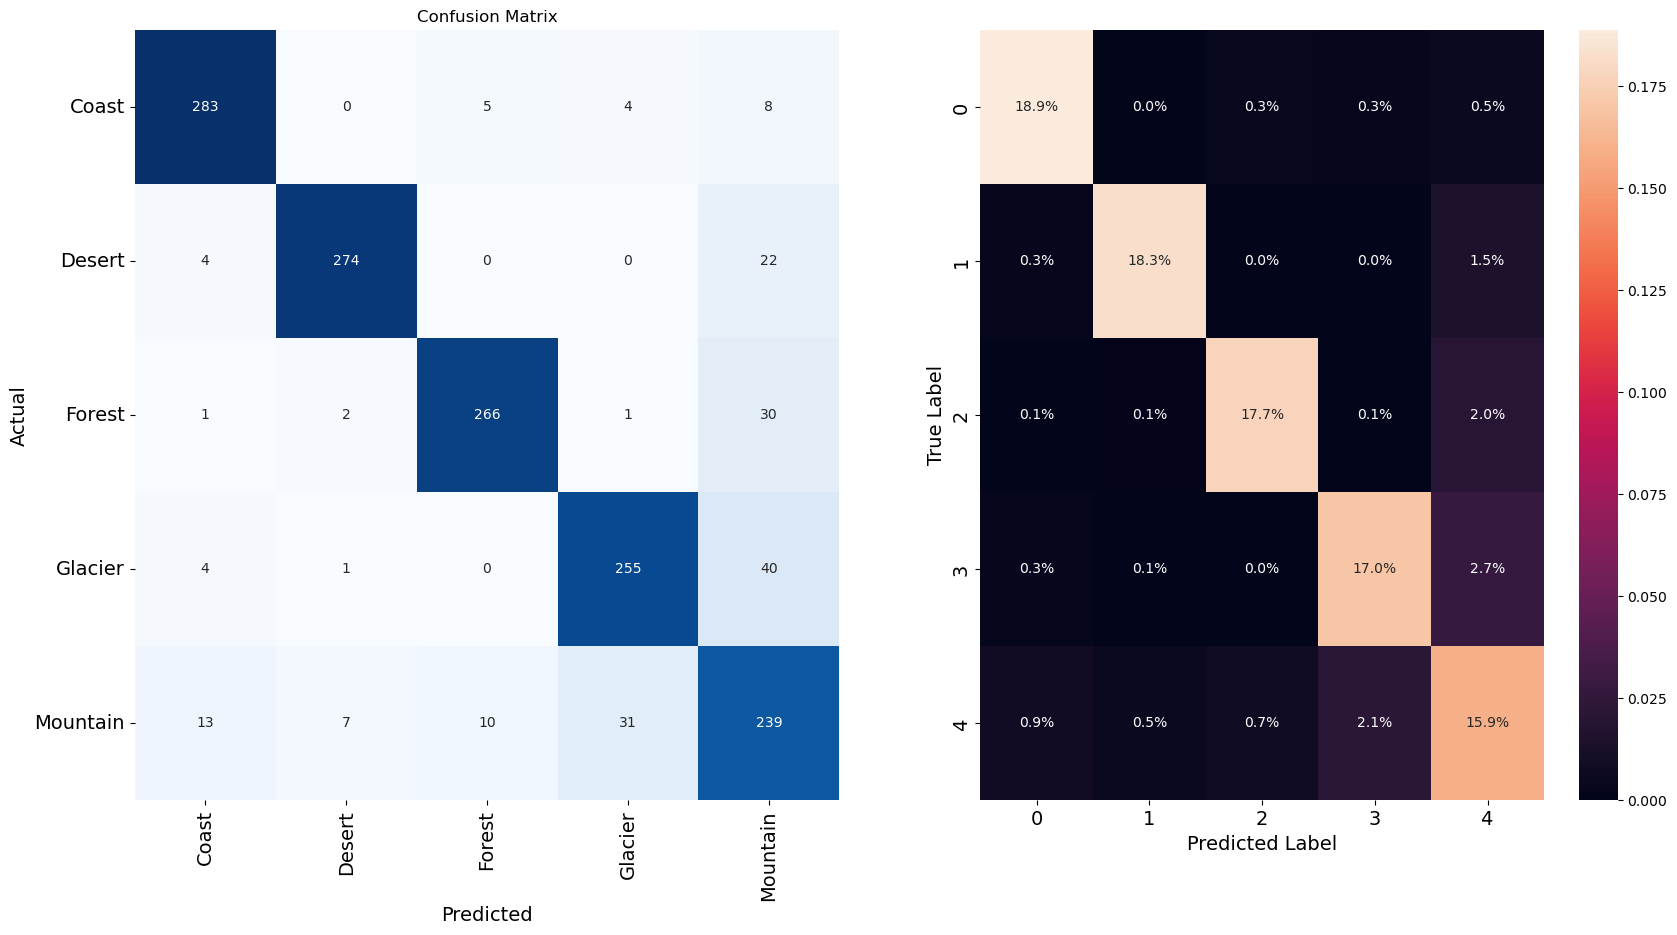

Classification Report:
----------------------
               precision    recall  f1-score   support

       Coast     0.9279    0.9433    0.9355       300
      Desert     0.9648    0.9133    0.9384       300
      Forest     0.9466    0.8867    0.9157       300
     Glacier     0.8763    0.8500    0.8629       300
    Mountain     0.7050    0.7967    0.7480       300

    accuracy                         0.8780      1500
   macro avg     0.8841    0.8780    0.8801      1500
weighted avg     0.8841    0.8780    0.8801      1500

In [6]:
# Inference code
model_path = "./output-deit3/best_checkpoint.pth"
test_data_path = "../Dataset/Landscape Classification/val"

cfg = {
    "num_classes": 5,
    "input_size": (3, 224, 224),
    "pool_size": None,
    "crop_pct": 0.9,
    "interpolation": "bicubic",
    "fixed_input_size": True,
    "mean": IMAGENET_DEFAULT_MEAN,
    "std": IMAGENET_DEFAULT_STD,
    "first_conv": "patch_embed.proj",
    "classifier": "head",
}

model = create_model(
    "deit_small_patch16_LS",
    pretrained=False,
    num_classes=5,
    drop_path=0.0,
    input_size=(3, 224, 224),
)

loader = create_loader(
    ImageDataset(test_data_path),
    input_size=input_size,
    batch_size=batch_size,
    use_prefetcher=True,
    interpolation="bicubic",
    mean=IMAGENET_DEFAULT_MEAN,
    std=IMAGENET_DEFAULT_STD,
    num_workers=8,
    crop_pct=0.9,
)

# Modifying the positional embedding since this checkpoint is finetuned from a model that initially had 1000 classes
checkpoint = torch.load(model_path, map_location="cpu")
checkpoint_model = checkpoint["model"]

pos_embed_checkpoint = checkpoint_model["pos_embed"]

print(
    "shape of positional embedding in the loaded checkpoint", pos_embed_checkpoint.shape
)

embedding_size = pos_embed_checkpoint.shape[-1]
num_patches = model.patch_embed.num_patches
num_extra_tokens = model.pos_embed.shape[-2] - num_patches
# height (== width) for the checkpoint position embedding
orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
# height (== width) for the new position embedding
new_size = int(num_patches**0.5)
# class_token and dist_token are kept unchanged
extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
# only the position tokens are interpolated
pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(
    0, 3, 1, 2
)
pos_tokens = torch.nn.functional.interpolate(
    pos_tokens, size=(new_size, new_size), mode="bicubic", align_corners=False
)
pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
checkpoint_model["pos_embed"] = new_pos_embed


model.load_state_dict(checkpoint_model, strict=False)
model.cuda()

try:
    json_file = open("./class_indices.json", "r")
    class_indict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)


def predictor(testloader):
    errors = 0
    y_pred, y_true = [], []

    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # print(f"images:{images.shape}, labels:{labels}, datatype: {images.dtype}")
            images, labels = images.to(device), labels.to(device)
            preds = torch.argmax(model(images), dim=1)
            for i in range(len(preds)):
                y_pred.append(preds[i].cpu())
                y_true.append(labels[i].cpu())

    tests = len(y_pred)
    for i in range(tests):
        pred_index = y_pred[i]
        true_index = y_true[i]
        if pred_index != true_index:
            errors += 1
    acc = (1 - errors / tests) * 100
    print(f"there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%")

    ypred = np.array(y_pred)
    ytrue = np.array(y_true)

    f1score = f1_score(ytrue, ypred, average="weighted") * 100
    print(f"The F1-score was {f1score:.3f}")

    class_count = len(list(class_indict.values()))
    classes = list(class_indict.values())

    cm = confusion_matrix(ytrue, y_pred)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, vmin=0, fmt="g", cmap="Blues", cbar=False)
    plt.xticks(np.arange(class_count) + 0.5, classes, rotation=90, fontsize=14)
    plt.yticks(np.arange(class_count) + 0.5, classes, rotation=0, fontsize=14)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.title("Confusion Matrix")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm / np.sum(cm), annot=True, fmt=".1%")
    plt.xlabel("Predicted Label", fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return f1score


f1score = predictor(loader)

### EfficientNet B3

The created class indices are: 

{'Coast': 0, 'Desert': 1, 'Forest': 2, 'Glacier': 3, 'Mountain': 4}

Training Images:

Mountain               : 100%|████████████████████████████████████████| 2000/2000 [00:01<00:00, 1676.07file/s]


Validation Images:

Mountain               : 100%|██████████████████████████████████████████| 300/300 [00:00<00:00, 1462.25file/s]


5 kind of training images were found in the dataset

5 kind of validation images were found in the dataset

training_filepaths labels_train
6626  ../Dataset/Landscape Classification/train/Glac...      Glacier
6852  ../Dataset/Landscape Classification/train/Glac...      Glacier
298   ../Dataset/Landscape Classification/train/Coas...        Coast
6884  ../Dataset/Landscape Classification/train/Glac...      Glacier
2868  ../Dataset/Landscape Classification/train/Dese...       Desert
1966  ../Dataset/Landscape Classification/train/Coas...        Coast
1272  ../Dataset/Landscape Classification/train/Coas...        Coast
9647  ../Dataset/Landscape Classification/train/Moun...     Mountain
2179  ../Dataset/Landscape Classification/train/Dese...       Desert
4917  ../Dataset/Landscape Classification/train/Fore...       Forest
5190  ../Dataset/Landscape Classification/train/Fore...       Forest
7677  ../Dataset/Landscape Classification/train/Glac...      Glacier
8895  ../Dataset/Landscape Classification/train/Moun...     Mountain
8519  ../Dataset/Landscape Classification/train/Moun...     Mountain
8549  ../Dataset/Landscape Classification/train/Moun...     Mountain
7835  ../Dataset/Landscape Classification/train/Glac...      Glacier
9362  ../Dataset/Landscape Classification/train/Moun...     Mountain
8203  ../Dataset/Landscape Classification/train/Moun...     Mountain
1152  ../Dataset/Landscape Classification/train/Coas...        Coast
1781  ../Dataset/Landscape Classification/train/Coas...        Coast
491   ../Dataset/Landscape Classification/train/Coas...        Coast
9901  ../Dataset/Landscape Classification/train/Moun...     Mountain
9872  ../Dataset/Landscape Classification/train/Moun...     Mountain
3091  ../Dataset/Landscape Classification/train/Dese...       Desert
8779  ../Dataset/Landscape Classification/train/Moun...     Mountain
1630  ../Dataset/Landscape Classification/train/Coas...        Coast
6248  ../Dataset/Landscape Classification/train/Glac...      Glacier
7825  ../Dataset/Landscape Classification/train/Glac...      Glacier
1911  ../Dataset/Landscape Classification/train/Coas...        Coast
7518  ../Dataset/Landscape Classification/train/Glac...      Glacier
1475  ../Dataset/Landscape Classification/train/Coas...        Coast
9042  ../Dataset/Landscape Classification/train/Moun...     Mountain
8629  ../Dataset/Landscape Classification/train/Moun...     Mountain
5241  ../Dataset/Landscape Classification/train/Fore...       Forest
1325  ../Dataset/Landscape Classification/train/Coas...        Coast
7922  ../Dataset/Landscape Classification/train/Glac...      Glacier
7155  ../Dataset/Landscape Classification/train/Glac...      Glacier
6913  ../Dataset/Landscape Classification/train/Glac...      Glacier
2119  ../Dataset/Landscape Classification/train/Dese...       Desert
4274  ../Dataset/Landscape Classification/train/Fore...       Forest
1257  ../Dataset/Landscape Classification/train/Coas...        Coast
4379  ../Dataset/Landscape Classification/train/Fore...       Forest
9565  ../Dataset/Landscape Classification/train/Moun...     Mountain
5030  ../Dataset/Landscape Classification/train/Fore...       Forest
8226  ../Dataset/Landscape Classification/train/Moun...     Mountain
2990  ../Dataset/Landscape Classification/train/Dese...       Desert
3376  ../Dataset/Landscape Classification/train/Dese...       Desert
1659  ../Dataset/Landscape Classification/train/Coas...        Coast
2348  ../Dataset/Landscape Classification/train/Dese...       Desert
314   ../Dataset/Landscape Classification/train/Coas...        Coast

validation_filepaths labels_validation
752   ../Dataset/Landscape Classification/val/Forest...            Forest
34    ../Dataset/Landscape Classification/val/Coast/...             Coast
552   ../Dataset/Landscape Classification/val/Desert...            Desert
297   ../Dataset/Landscape Classification/val/Coast/...             Coast
572   ../Dataset/Landscape Classification/val/Desert...            Desert
856   ../Dataset/Landscape Classification/val/Forest...            Forest
207   ../Dataset/Landscape Classification/val/Coast/...             Coast
750   ../Dataset/Landscape Classification/val/Forest...            Forest
1438  ../Dataset/Landscape Classification/val/Mounta...          Mountain
1240  ../Dataset/Landscape Classification/val/Mounta...          Mountain
1457  ../Dataset/Landscape Classification/val/Mounta...          Mountain
579   ../Dataset/Landscape Classification/val/Desert...            Desert
410   ../Dataset/Landscape Classification/val/Desert...            Desert
1224  ../Dataset/Landscape Classification/val/Mounta...          Mountain
1174  ../Dataset/Landscape Classification/val/Glacie...           Glacier
1078  ../Dataset/Landscape Classification/val/Glacie...           Glacier
127   ../Dataset/Landscape Classification/val/Coast/...             Coast
831   ../Dataset/Landscape Classification/val/Forest...            Forest
955   ../Dataset/Landscape Classification/val/Glacie...           Glacier
302   ../Dataset/Landscape Classification/val/Desert...            Desert
1117  ../Dataset/Landscape Classification/val/Glacie...           Glacier
1255  ../Dataset/Landscape Classification/val/Mounta...          Mountain
976   ../Dataset/Landscape Classification/val/Glacie...           Glacier
599   ../Dataset/Landscape Classification/val/Desert...            Desert
434   ../Dataset/Landscape Classification/val/Desert...            Desert
787   ../Dataset/Landscape Classification/val/Forest...            Forest
963   ../Dataset/Landscape Classification/val/Glacie...           Glacier
1035  ../Dataset/Landscape Classification/val/Glacie...           Glacier
57    ../Dataset/Landscape Classification/val/Coast/...             Coast
1199  ../Dataset/Landscape Classification/val/Glacie...           Glacier
72    ../Dataset/Landscape Classification/val/Coast/...             Coast
868   ../Dataset/Landscape Classification/val/Forest...            Forest
674   ../Dataset/Landscape Classification/val/Forest...            Forest
975   ../Dataset/Landscape Classification/val/Glacie...           Glacier
769   ../Dataset/Landscape Classification/val/Forest...            Forest
1022  ../Dataset/Landscape Classification/val/Glacie...           Glacier
1357  ../Dataset/Landscape Classification/val/Mounta...          Mountain
1496  ../Dataset/Landscape Classification/val/Mounta...          Mountain
1132  ../Dataset/Landscape Classification/val/Glacie...           Glacier
573   ../Dataset/Landscape Classification/val/Desert...            Desert
1057  ../Dataset/Landscape Classification/val/Glacie...           Glacier
259   ../Dataset/Landscape Classification/val/Coast/...             Coast
854   ../Dataset/Landscape Classification/val/Forest...            Forest
629   ../Dataset/Landscape Classification/val/Forest...            Forest
802   ../Dataset/Landscape Classification/val/Forest...            Forest
557   ../Dataset/Landscape Classification/val/Desert...            Desert
995   ../Dataset/Landscape Classification/val/Glacie...           Glacier
1176  ../Dataset/Landscape Classification/val/Glacie...           Glacier
684   ../Dataset/Landscape Classification/val/Forest...            Forest
331   ../Dataset/Landscape Classification/val/Desert...            Desert

average image height=  191   average image width=  268  aspect ratio h/w=  0.7126865671641791

10000 images were found in the dataset.
10000 for training, 1500 for validation

Training Image

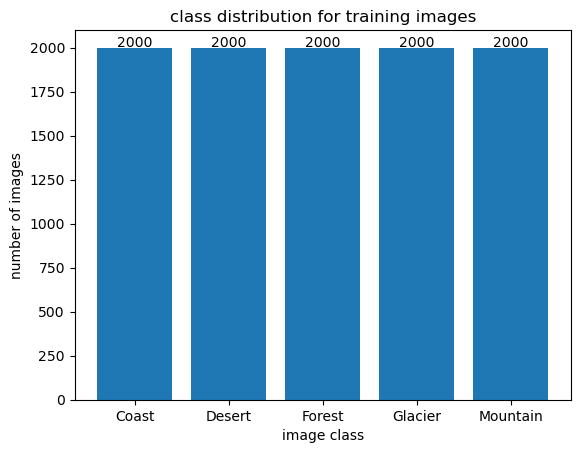

/home/mohanakrishna/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mohanakrishna/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
train_image_path, train_image_label, val_image_path, val_image_label, class_indices = (
    read_split_data(root, plot_image=True)
)


class MyDataset(Dataset):
    def __init__(self, image_path, image_labels, transforms=None):
        self.image_path = image_path
        self.image_labels = image_labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image = Image.open(self.image_path[idx]).convert("RGB")
        label = self.image_labels[idx]
        if self.transforms:
            image = self.transforms(image)
        return image, label

    @staticmethod
    def collate_fn(batch):
        images, labels = tuple(zip(*batch))
        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels


device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 32
epochs = 5
weight_decay = 1e-5
lr = 0.001

data_transform = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "valid": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

train_dataset = MyDataset(train_image_path, train_image_label, data_transform["train"])
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=train_dataset.collate_fn,
)

valid_dataset = MyDataset(val_image_path, val_image_label, data_transform["valid"])
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=valid_dataset.collate_fn,
)

net = torchvision.models.efficientnet_b3(pretrained=True)
# finetune_net.classifier
net.classifier = nn.Sequential(
    nn.Dropout(0.4, inplace=True),
    nn.Linear(1536, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 5),
)
net = net.to(device)

In [ ]:
# Training code
def train_step(net, optimizer, data_loader, device, epoch):
    net.train()
    loss_function = nn.CrossEntropyLoss()
    train_acc, train_loss, sampleNum = 0, 0, 0

    optimizer.zero_grad()

    train_bar = tqdm(data_loader, file=sys.stdout, colour="red")
    for step, data in enumerate(train_bar):
        images, labels = data
        sampleNum += images.shape[0]
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()
        loss.backward()
        optimizer.step()
        train_bar.desc = "[train epoch {}] loss: {:.3f}, acc: {:.3f}".format(
            epoch, train_loss / (step + 1), train_acc / sampleNum
        )

    return train_loss / (step + 1), train_acc / sampleNum


@torch.no_grad()
def val_step(net, data_loader, device, epoch):
    loss_function = nn.CrossEntropyLoss()
    net.eval()
    val_acc = 0
    val_loss = 0
    sample_num = 0
    val_bar = tqdm(data_loader, file=sys.stdout, colour="red")
    for step, data in enumerate(val_bar):
        images, labels = data
        sample_num += images.shape[0]
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = loss_function(outputs, labels)
        val_loss += loss.item()
        val_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()
        val_bar.desc = "[valid epoch {}] loss: {:.3f}, acc: {:.3f}".format(
            epoch, val_loss / (step + 1), val_acc / sample_num
        )

    return val_loss / (step + 1), val_acc / sample_num


optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

best_val_acc = 0

for epoch in range(15):
    train_loss, train_accuracy = train_step(net, optimizer, train_loader, device, epoch)
    val_loss, val_accuracy = val_step(net, valid_loader, device, epoch)

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy

        if not os.path.exists("output-efficientnet-b3"):
            os.mkdir("output-efficientnet-b3")

        torch.save(net.state_dict(), f"./output-efficientnet-b3/model_{epoch}.pth")

In [ ]:
# Inference code
try:
    json_file = open("./classes_indices.json", "r")
    class_indict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)


def predictor(testloader):
    errors = 0
    y_pred, y_true = [], []

    save_path = "./output-efficientnet-b3/model_13.pth"
    assert os.path.exists(save_path)
    net.load_state_dict(torch.load(save_path))

    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            preds = torch.argmax(net(images), dim=1)
            for i in range(len(preds)):
                y_pred.append(preds[i].cpu())
                y_true.append(labels[i].cpu())

    tests = len(y_pred)
    for i in range(tests):
        pred_index = y_pred[i]
        true_index = y_true[i]
        if pred_index != true_index:
            errors += 1
    acc = (1 - errors / tests) * 100
    print(f"there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%")

    ypred = np.array(y_pred)
    ytrue = np.array(y_true)

    f1score = f1_score(ytrue, ypred, average="weighted") * 100
    print(f"The F1-score was {f1score:.3f}")

    class_count = len(list(class_indict.values()))
    classes = list(class_indict.values())

    cm = confusion_matrix(ytrue, y_pred)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, vmin=0, fmt="g", cmap="Blues", cbar=False)
    plt.xticks(np.arange(class_count) + 0.5, classes, rotation=90, fontsize=14)
    plt.yticks(np.arange(class_count) + 0.5, classes, rotation=0, fontsize=14)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.title("Confusion Matrix")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm / np.sum(cm), annot=True, fmt=".1%")
    plt.xlabel("Predicted Label", fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return f1score


f1score = predictor(valid_loader)

### YoloV8

In [13]:
# Load the pretrained yolo-v8-cls (classification)
model = YOLO("yolov8n-cls.pt")
result = model.train(data="../Dataset/Landscape Classification/", epochs=300, imgsz=224)

100%|██████████| 5.30M/5.30M [00:05<00:00, 1.09MB/s]


New https://pypi.org/project/ultralytics/8.2.51 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.38 🚀 Python-3.11.5 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090 Laptop GPU, 15981MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=../Dataset/Landscape Classification/, epochs=300, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

100%|██████████| 6.23M/6.23M [00:00<00:00, 9.32MB/s]
/home/mohanakrishna/anaconda3/lib/python3.11/site-packages/ultralytics/utils/torch_utils.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/home/mohanakrishna/anaconda3/lib/python3.11/site-packages/ultralytics/utils/torch_utils.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_determini

AMP: checks passed ✅


train: Scanning /home/mohanakrishna/Development/GSSoC/terrain classification/Dataset/Landscape Classification/train... 10000 images, 0 corrupt: 100%|██████████| 10000/10000 [00:04<00:00, 2429.65it/s]


train: New cache created: /home/mohanakrishna/Development/GSSoC/terrain classification/Dataset/Landscape Classification/train.cache


val: Scanning /home/mohanakrishna/Development/GSSoC/terrain classification/Dataset/Landscape Classification/val... 1500 images, 0 corrupt: 100%|██████████| 1500/1500 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/classify/train
Starting training for 300 epochs...

      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/625 [00:00<?, ?it/s]/home/mohanakrishna/anaconda3/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      1/300      1.28G      1.589         16        224:   0%|          | 1/625 [00:01<15:12,  1.46s/it]/home/mohanakrishna/anaconda3/lib/python3.11/site-packages/torch/autog

KeyboardInterrupt: 

In [ ]:
test_data_path = "../Dataset/Landscape Classification"

# Comment or Uncomment the line to disbale or enable validation
!yolo task=classify mode=val model= "/home/mohanakrishna/Development/GSSoC/terrain classification/Model/Yolov8/runs/classify/train3/weights/best.pt" data="{test_data_path}"

# Display the results
val_results_path = "./runs/classify/val"

# Load the Confusion Matrix results
for image_path in glob(f"{val_results_path}/*.png")[:3]:
    if "confusion_matrix" in image_path:
        if "normalized" in image_path:
            print("Confusion Matrix Normalized")
        else:
            print("Confusion Matrix")
        display(Image(filename=image_path, width=600))
        print("\n")

In [ ]:
# Inference

image_path = "../../Images/Desert-Test (10).jpeg"

model = YOLO("./runs/classify/train3/weights/best.pt")

# use with stream for better memory efficiency
results = model.predict(
    source=image_path, conf=0.5, imgsz=224, classes=[0, 1, 2, 3, 4], stream=True
)

for result in results:
    result.save(filename="result.jpg")

for image_path in glob(f"./*.jpg")[:3]:
    display(Image(filename=image_path, width=600))
    print("\n")